# Prototype hybrid matrix factorization model for drug reccomendations using PyTorch

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F

from sklearn import metrics

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset

## Load KINOMEscan preprocessed dataset with intersection of proteins screened for drugs

In [3]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


## Model definition

In [5]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.zeros(drug_outputs.shape[0])
        for k in range(drug_outputs.shape[1]):
            final_outputs = final_outputs + drug_outputs[:, k] * cell_line_outputs[:, k]
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs
    
def evaluate_predictions(y_true, preds):
    """Compute RMSE and correlation with true values for model predictions"""
    print("RMSE:", metrics.mean_squared_error(y_true, preds) ** 0.5)
    print("Correlation:", pearsonr(y_true, preds))

## Data preprocessing

Establish drug response data

In [6]:
response_df = full_dataset.response_data
response_df = response_df.sample(frac=1., random_state=2)
print(response_df.shape, response_df.COSMIC_ID.nunique())
response_df.head(3)

(55936, 3) 987


,DRUG_ID,COSMIC_ID,AUC
100607,283,724868,0.646775
48438,1560,1298533,0.936290
83416,260,906693,0.860301


In [7]:
# Split the data into train, validation and test, without separating any cell lines
test_ratio = 0.25
val_number = 100

# Split into train/test set
train_samples = response_df[int(test_ratio * response_df.shape[0]):]
test_samples = response_df[:int(test_ratio * response_df.shape[0])]

# Split test set into validation/held-out test
val_samples = test_samples[-val_number:]
test_samples = test_samples[:-val_number]
print(train_samples.shape, val_samples.shape, test_samples.shape)

(41952, 3) (100, 3) (13884, 3)


Establish cell line data

In [8]:
cell_line_data_df = full_dataset.full_cell_lines_data
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(922, 225)


,cell_line_id,PRKX_exp,TIE1_exp,BMPR2_exp,PKMYT1_exp,ABL2_exp,PLK1_exp,ACVR1_exp,MAP3K4_mut,SRPK1_exp,...,Tissue_lung_SCLC,Tissue_lymphoma,Tissue_myeloma,Tissue_nervous_system,Tissue_neuroblastoma,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system
cell_line_id,,,,,,,,,,,,,,,,,,,,,
906826,906826,4.787607,3.056350,6.395463,5.550737,5.492917,3.853142,4.384087,0,7.410108,...,0,0,0,0,0,0,0,0,0,0
687983,687983,5.001763,3.125097,6.634672,5.399054,5.113815,4.218736,4.786061,0,7.776150,...,1,0,0,0,0,0,0,0,0,0
910927,910927,5.459631,2.989998,7.945827,5.541005,4.519127,3.694307,4.414635,0,7.079021,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
print(len(missing_cell_lines))

66


In [10]:
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_df.index = cell_line_data_df.cell_line_id
cell_line_data_df = cell_line_data_df.drop("cell_line_id", axis=1)

In [11]:
# Extract response only for cell lines for which features are present
print(response_df.shape)
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]
print(response_df.shape)

(55936, 3)
(52730, 3)


Establish drug features data

In [12]:
drug_data_df = full_dataset.drugs_data
print(drug_data_df.shape)
# Convert drug index from LINCS name to GDSC drug ID
drug_data_df.index = drug_data_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
drug_data_df.head(3)

(74, 294)


Protein,MAPKAPK2,MARK1,CAMKK2,MARK2,TGFBR1,ERK5,EPHA7,MK01,RAF1,TNNI3K,...,KGP1,ZAP70,ERK3,BLK,MYLK2,KPCD3,FGFR3,ACVR1,GSK3A,KPCD
Small Molecule,,,,,,,,,,,,,,,,,,,,,
1242,100.0,83.0,88.0,96.0,57.0,100.0,92.0,64.0,100.0,77.0,...,99.0,86.0,98.0,57.0,80.0,12.0,95.0,1.9,100.0,100.0
86,100.0,100.0,2.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.7,100.0,100.0,100.0,100.0,1.6,100.0,100.0,1.0,0.9
29,100.0,100.0,28.0,92.0,100.0,100.0,84.0,100.0,2.3,15.0,...,100.0,100.0,100.0,1.0,100.0,88.0,100.0,100.0,100.0,89.0


In [13]:
# Search for drugs present in response data, but missing the drug features
missing_drugs = []
for drug_id in response_df.DRUG_ID.unique():
    if drug_id not in drug_data_df.index:
        print(drug_id)
        missing_drugs.append(drug_id)
print(len(missing_drugs))

0


Split drug response data into training/validation/test 

In [14]:
print(cell_line_data_df.shape, drug_data_df.index.nunique(), cell_line_data_df.index.nunique())
print(response_df.shape, response_df.DRUG_ID.nunique(), response_df.COSMIC_ID.nunique())

(922, 224) 74 922
(52730, 3) 74 921


In [15]:
# Split the data into train, validation and test, without separating any cell lines
test_ratio = 0.25
val_number = 100

# Split into train/test set
train_samples = response_df[int(test_ratio * response_df.shape[0]):]
test_samples = response_df[:int(test_ratio * response_df.shape[0])]

# Split test set into validation/held-out test
val_samples = test_samples[-val_number:]
test_samples = test_samples[:-val_number]
print(train_samples.shape, val_samples.shape, test_samples.shape)

(39548, 3) (100, 3) (13082, 3)


In [2]:
39548 + 13082 + 100

52730

Normalize / standardize the data

In [16]:
# Cell line data
cols_subset = [col for col in list(cell_line_data_df) if col.endswith("_exp")]
rows_subset = None

cell_line_data_df = Dataset.standardize_data(cell_line_data_df, cols_subset=cols_subset)
print(cell_line_data_df.shape, cell_line_data_df.mean().mean(),
     cell_line_data_df.std().sum())

(922, 224) 0.005679617291601466 193.9090086389599


In [17]:
# Drug data
print(drug_data_df.shape)
drug_data_df = Dataset.standardize_data(drug_data_df)
print(drug_data_df.shape, drug_data_df.mean().mean(),
     drug_data_df.std().sum())

(74, 294)
(74, 294) 2.196104424744604e-17 294.0


## Model training

In [1]:
74 * 922

68228

In [18]:
train_samples = train_samples.sample(10, random_state=2)
print(train_samples.shape, train_samples["AUC"].sum())

(10, 3) 7.488004


In [22]:
# Specify hyperparameters
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]


learning_rate = 0.001
epochs = 100
output_dim = 10
batch_size = 16
no_batches = train_samples.shape[0] // batch_size

model = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

In [23]:
# Check out the shapes of the model's parameters 
for p in model.parameters():
    print(p.shape)

torch.Size([10, 294])
torch.Size([10])
torch.Size([10, 224])
torch.Size([10])


In [24]:
# Training the model
model.train()
for epoch in range(epochs):
    for batch in range(no_batches + 1):
        # Separate response variable batch
        if batch != no_batches:
            samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
        else:
            samples_batch = train_samples.iloc[batch * batch_size:]
            
        # Extract output variable batch
        y_batch = torch.from_numpy(samples_batch["AUC"].values)
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = samples_batch["COSMIC_ID"].values
        # Extract corresponding cell line data
        cell_line_input_batch = cell_line_data_df.loc[cl_ids].values
        cell_line_input_batch = torch.from_numpy(cell_line_input_batch)
        
        # Extract drug IDs for which data shall be extracted
        drug_ids = samples_batch["DRUG_ID"].values
        # Extract corresponding drug data
        drug_input_batch = drug_data_df.loc[drug_ids].values
        drug_input_batch = torch.from_numpy(drug_input_batch)
        
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, 
        # dont want to cummulate gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        batch_output = model(drug_input_batch.float(), cell_line_input_batch.float())
        # Compute the loss for this batch
        loss = criterion(batch_output, y_batch.float())
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        #print("Epoch {}, batch {}, loss: {:.3f}".format(epoch + 1, batch + 1, loss.item()))
    #print(cell_line_input_batch[3].sum())
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.9399
Epoch 2, loss: 0.4973
Epoch 3, loss: 0.3323
Epoch 4, loss: 0.2442
Epoch 5, loss: 0.1881
Epoch 6, loss: 0.1482
Epoch 7, loss: 0.1180
Epoch 8, loss: 0.0944
Epoch 9, loss: 0.0757
Epoch 10, loss: 0.0607
Epoch 11, loss: 0.0487
Epoch 12, loss: 0.0390
Epoch 13, loss: 0.0313
Epoch 14, loss: 0.0250
Epoch 15, loss: 0.0200
Epoch 16, loss: 0.0159
Epoch 17, loss: 0.0127
Epoch 18, loss: 0.0101
Epoch 19, loss: 0.0080
Epoch 20, loss: 0.0064
Epoch 21, loss: 0.0051
Epoch 22, loss: 0.0040
Epoch 23, loss: 0.0032
Epoch 24, loss: 0.0025
Epoch 25, loss: 0.0020
Epoch 26, loss: 0.0016
Epoch 27, loss: 0.0012
Epoch 28, loss: 0.0010
Epoch 29, loss: 0.0008
Epoch 30, loss: 0.0006
Epoch 31, loss: 0.0005
Epoch 32, loss: 0.0004
Epoch 33, loss: 0.0003
Epoch 34, loss: 0.0002
Epoch 35, loss: 0.0002
Epoch 36, loss: 0.0001
Epoch 37, loss: 0.0001
Epoch 38, loss: 0.0001
Epoch 39, loss: 0.0001
Epoch 40, loss: 0.0001
Epoch 41, loss: 0.0000
Epoch 42, loss: 0.0000
Epoch 43, loss: 0.0000
Epoch 44, loss: 0.00

## Model evaluation

#### Evaluate on training data

In [25]:
# Do some sample predictions on trainig data
# Sample data points
sample = train_samples.sample(2)
sample

,DRUG_ID,COSMIC_ID,AUC
216474,1052,1290730,0.948875
12001,87,753621,0.504412


In [26]:
# Do some predictions on training data
cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(drug_input)).float(), 
                     Variable(torch.from_numpy(cl_input)).float())
print(predicted)

tensor([0.9489, 0.5044])


In [27]:
print(model.drug_linear.weight.shape, model.drug_linear.bias.shape)
print(model.cell_line_linear.weight.shape, model.cell_line_linear.bias.shape)

torch.Size([10, 294]) torch.Size([10])
torch.Size([10, 224]) torch.Size([10])


In [28]:
# Do predictions manually
drug_out = torch.from_numpy(drug_input[0].reshape(-1, 294)).float() @ model.drug_linear.weight.t() + \
                                                                    model.drug_linear.bias
cl_out = torch.from_numpy(cl_input[0].reshape(-1, 224)).float() @ model.cell_line_linear.weight.t() + \
                                                            model.cell_line_linear.bias
final_out = torch.zeros(drug_out.shape[0])
for k in range(drug_out.shape[1]):
    final_out = final_out + drug_out[:, k] * cl_out[:, k]
print(final_out.shape, final_out)

torch.Size([1]) tensor([0.9489], grad_fn=<AddBackward0>)


In [29]:
# Predict on a bigger sample of trainig data
sample = train_samples.iloc[:val_samples.shape[0]]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([sample["AUC"].mean()] * sample.shape[0]) + \
             np.random.normal(loc=0, scale=0.01, size=sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()
print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted)

torch.Size([10]) tensor(0.9915) tensor(0.3988) tensor(0.7488)
Baseline scores:
RMSE: 0.21716751958937125
Correlation: (-0.3881833670272419, 0.2676507213733762)

Model scores:
tensor(0.9915) tensor(0.3988) tensor(0.7488)
RMSE: 5.216127963461507e-06
Correlation: (0.9999999997543535, 1.5930169689690508e-38)


#### Evaluation on validation set

In [30]:
print(val_samples.shape)
val_samples.head(5)

(100, 3)


,DRUG_ID,COSMIC_ID,AUC
224171,1066,905959,0.842805
86520,1873,1240223,0.811188
56137,1614,1298347,0.990067
215301,1050,909740,0.969985
65582,223,910924,0.685411


In [33]:
# Predict on validation data and evaluate
sample = val_samples[:]
y_true = sample["AUC"].values

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted)

Model scores:
tensor(3.4806) tensor(-2.5619) tensor(-0.1212)
RMSE: 1.4158125125649392
Correlation: (0.005336217845266272, 0.9579775911729909)


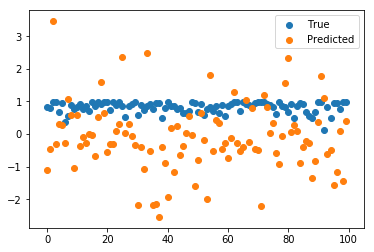

In [34]:
# Plot predictions and trye values
k = 100
xs = list(zip(sample["DRUG_ID"], sample["COSMIC_ID"]))
xs = np.arange(k)

plt.scatter(xs, y_true[:k], label="True")
plt.scatter(xs, predicted.numpy()[:k], label="Predicted")

plt.legend()
plt.show()

#### Evaluate on unseen cell lines

In [38]:
# Predict on unseen cell lines and evaluate
sample = separate_cell_lines_samples
y_true = sample["AUC"].values

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted)

NameError: name 'separate_cell_lines_samples' is not defined

## Wrap modeling process in classes and functions

In [1]:
class Model:
    pass